In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uncertainties as unt
import uncertainties.unumpy as unp
import pylab
import scipy.stats as st
import scipy.odr as odr
pylab.rcParams['figure.figsize'] = (14, 7)

In [10]:
1e400 * 1e-400

nan

In [3]:
# Constantes

b = unt.ufloat(6.17e-4, 0.03e-4) * 1333.2239 / 100 # Constante - Pa * m
n_0 = unt.ufloat(1.89E-05, 0.1e-5) # Viscosidade do ar - Kg / (m * s) 
g = unt.ufloat(9.7864, 0.0005) # Aceleração da gravidade - m / s²
dens = unt.ufloat(0.8474, 0.0009) * 1000 # Densidade do óleo - kg / m³
dens_ar = unt.ufloat(1.184, 0.03) # Densidade do ar - kg / m³
q_e = unt.ufloat(1.60E-19, 9.80E-28) # Carga elementar - C

In [4]:
# Medições

p = unt.ufloat(93645.646736, 53.328956) # Pressão atmosférica - Pa
d = unt.ufloat(4.5, 0.02) * 1e-3 # Distância entre as placas - m
V = unt.ufloat(100, 1) # Tensão entre as placas - V
T = unt.ufloat(25, 1) # Temperatura - C

ds = pd.read_csv("dados.csv")
v_s = unp.uarray(ds.vs, ds.s_vs) # Velocidade de subida - m/s
v_d = unp.uarray(ds.vd, ds.s_vd) # Velocidade de descida - m/s

#n_0 = 0.000181804 *((273.16 + T)/293.16) ** (3/2) * ((273.16 + T + 110.4)/(293.16 + 110.4)) / 10

In [5]:
# Obter o raio da gota

a = -b / (2 * p)    
f1 = (b ** 2) / (4 * p ** 2)
f2 = 9 * n_0 * (v_d - v_s)
f3 = (4 * g) * (dens - dens_ar)    
f4 = unp.sqrt(f1 + (f2 / f3))    
a += f4 # Raio da gota - m

In [6]:
# Corrigir a viscosidade do ar pelo raio da gota

n = n_0 * (1 + b / (p * a)) ** -1 # Viscosidade corrigida - Kg / (m * s)

In [7]:
# Obter a carga da gota

q = 3 * np.pi * n * a * d * (v_s + v_d) / V # Carga - C
f_q = q / q_e # Proporção carga / carga_elementar - sem unidade

In [8]:
f_q_nom = unp.nominal_values(f_q)
f_q_std = unp.std_devs(f_q)
a_nom = unp.nominal_values(a)

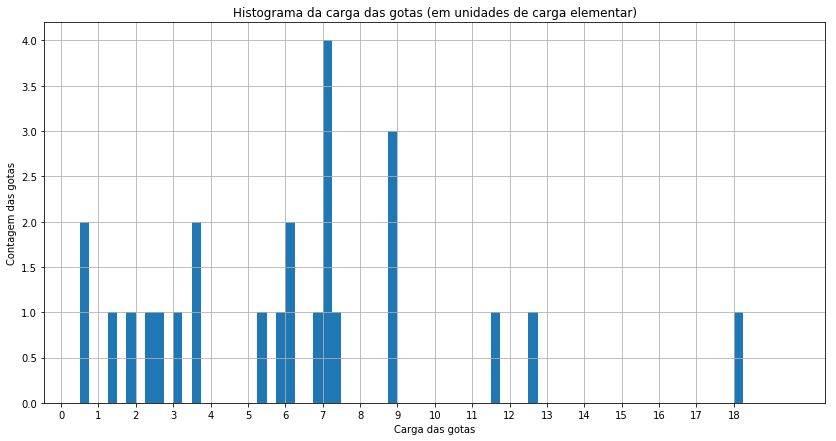

In [9]:
var = f_q_nom
qtd_bins = int(np.ceil(np.max(var))) * 4

plt.title("Histograma da carga das gotas (em unidades de carga elementar)")
plt.ylabel("Contagem das gotas")
plt.xlabel("Carga das gotas")
plt.hist(var, bins=qtd_bins, range=(0.5, qtd_bins / 4 + 0.5))
plt.xticks(np.arange(qtd_bins / 4))
plt.grid()
plt.show()

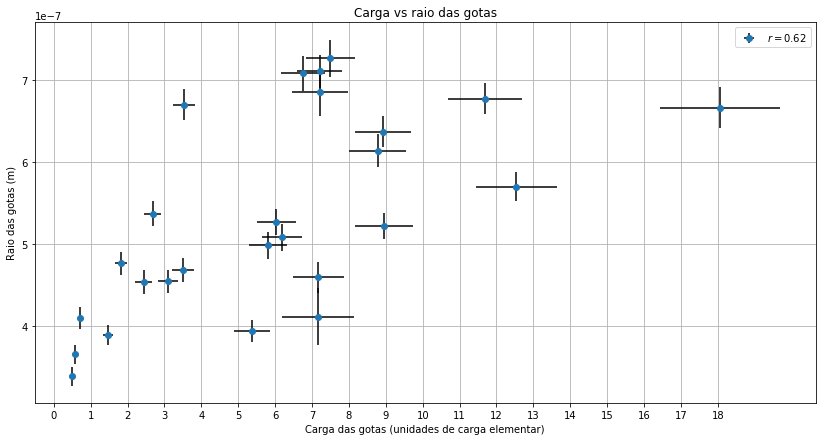

In [213]:
plt.title("Carga vs raio das gotas")
x = f_q_nom
y = a_nom
xerr = f_q_std
yerr = unp.std_devs(a)
r = st.pearsonr(x, y)[0]

def linear(B, x):
    return B[1] * x + B[0]

mydata = odr.RealData(x, y, sx=xerr, sy=yerr)
linear_model = odr.Model(linear)
myodr = odr.ODR(mydata, linear_model, beta0=[0, 0])
output = myodr.run()

x_aj = np.linspace(0, 20, 100)
y_aj = linear(output.beta, x_aj)
x_aju = []
y_aju = []
for i in range(len(x_aj)):
    (x_ajui, y_ajui) = unt.correlated_values([x_aj[i], y_aj[i]], output.cov_beta)
    x_aju.append(x_ajui)
    y_aju.append(y_ajui)
nom_xaj = [x.nominal_value for x in x_aju]
std_xaj = [x.std_dev for x in x_aju]
nom_yaj = [y.nominal_value for y in y_aju]
std_yaj = [y.std_dev for y in y_aju]

plt.ylabel("Raio das gotas (m)")
plt.xlabel("Carga das gotas (unidades de carga elementar)")
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', label="$r=%.3g$" % r, ecolor="k")
plt.xticks(np.arange(0, np.ceil(np.max(x))))
plt.legend()
plt.grid()
plt.show()

In [212]:
np.mean(a)

5.339183603284548e-07+/-1.5337626335005684e-08